###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 2: Book Rating Prediction

**Student IDs:**     1264462 & 1269549

# README

* To run the complete code in Jupyter Notebook, simply click Kernel > Restart & Run All.
    * Note that it might take a while to generate the output - the slowest model takes about < 7 minutes.
    * Alternatively, select the relevant cell, and click 'Run'.
* Code lines commented out with `##` are for printing out information that may be of interest. You may uncomment it to see the output.
* The dataset files (both the original and preprocessed) are assumed to exist in a folder named '**Datasets**', which resides in the same directory as this notebook.
* There are two helper notebooks in the same directory, namely "TextPreprocessing.ipynb" and "HelperFunctions.ipynb". Here we make use of the IPython built-in magic command (`%run`) to run these files. You do not need to open and run them separately.
* Each model may use a different version of the preprocessed dataset. Running this code generates the "train_df_ohe.csv" and "train_df_oe.csv" file. 
    * We have generated the other versions beforehand ("train_df_ohe_300", "train_df_oe_300"), which only requires a small change in a function parameter.
    * All required, preprocessed datasets lie in the 'Datasets' folder.
* This code also generates a file "predictions.csv", which are the final predictions made by the selected model on the test set.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, SelectKBest, SelectFromModel

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run TextPreprocessing.ipynb
%run HelperFunctions.ipynb

In [4]:
DATASET_DIR = "./Datasets/"
CLASS_LABEL = "rating_label"

In [5]:
# Load datasets
train_df = pd.read_csv(DATASET_DIR + "book_rating_train.csv", index_col = False, delimiter = ',', header=0)
test_df = pd.read_csv(DATASET_DIR + "book_rating_test.csv", index_col = False, delimiter = ',', header=0)
entire_df = pd.concat([train_df, test_df])

# 1. Data Preprocessing

Note: Here we show the individual preprocessing steps for the training set for clarity. At the end we pull everything together to preprocess the test set.

## Preprocess String features: Authors and Publisher

In [6]:
CATEGORICAL_FEATURES = ['Authors', 'Publisher']
MISSING_CAT_VAL = ''

In [7]:
train_df = train_df.drop('Language', axis=1)  # this feature has too many missing values

for df in [train_df, entire_df]:
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].fillna(MISSING_CAT_VAL)  # impute missing values
        df[feature] = df[feature].apply(lambda x: preprocess(x, stop_words_removal=False, lemmatize=False, min_word_len=0))

### Version 1: One-Hot Encoding
Some models will use different encodings of the categorical features.

In [8]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3, sparse=False)
OHE.fit(entire_df[CATEGORICAL_FEATURES])

OneHotEncoder(handle_unknown='infrequent_if_exist', min_frequency=3,
              sparse=False, sparse_output=False)

In [9]:
def ohe_transform(df, has_labels=False):
    """
    Transforms the dataset by one-hot-encoding, on the categorical features only.
    `has_label` indicates whether the DataFrame contains the class labels.
        If True, these are moved to the last column.
    Returns the transformed DataFrame.
    """
    transformed_mat = OHE.transform(df[CATEGORICAL_FEATURES])
    transformed_cat_df = pd.DataFrame(transformed_mat).set_axis(OHE.get_feature_names_out(), axis=1, inplace=False)
    transformed_df = pd.concat([df.reset_index(drop=True), transformed_cat_df], axis=1)
    transformed_df = transformed_df.drop(CATEGORICAL_FEATURES, axis=1)  # drop the original attributes
    
    if has_labels:
        # move rating_label to the last column
        labels = transformed_df[CLASS_LABEL]
        transformed_df = pd.concat([transformed_df.drop([CLASS_LABEL], axis=1), labels], axis=1)
    
    return transformed_df

In [10]:
ALPHA = 0.05

# Select one-hot-encoded features using chi2
x2 = SelectKBest(chi2, k='all')
x2.fit(ohe_transform(train_df)[OHE.get_feature_names_out()], train_df[CLASS_LABEL])
pvals = pd.DataFrame(x2.pvalues_, index=x2.feature_names_in_, columns=['p-value'])
## print(pvals)

INSIG_OHE_FEATURES = pvals[pvals['p-value'] >= ALPHA].index.tolist()  # insignificant encoded features
sig_ohe_features = pvals[pvals['p-value'] < ALPHA].index.tolist()
print(len(sig_ohe_features), "features are significant.")
## sig_ohe_features

497 features are significant.


### Version 2: Ordinal Encoding

In [11]:
from sklearn.preprocessing import OrdinalEncoder

ORD_ENCODER = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
ORD_ENCODER.fit(entire_df[CATEGORICAL_FEATURES])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [12]:
def ord_enc_transform(df):
    """
    Transforms the dataset by one-hot-encoding, on the categorical features only.
    Returns the transformed DataFrame.
    """
    df = df.copy()
    df[CATEGORICAL_FEATURES] = ORD_ENCODER.transform(df[CATEGORICAL_FEATURES])
    for i in range(len(CATEGORICAL_FEATURES)):  
        # some models (e.g. CategoricalNB), cannot handle negative values, so we replace -1 with the next unused int to denote unseen values
        df[CATEGORICAL_FEATURES[i]] = df[CATEGORICAL_FEATURES[i]].replace(-1, ORD_ENCODER.categories_[i].size)
    
    return df

## Discretize 'Numerical' features

In [13]:
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, feature, discretizer=None, strategy='kmeans', n_bins=5):
    """
    Discretizes the feature in the given DataFrame.
    - discretizer: the discretizer; 
      If None, creates a KBinsDiscretizer for ordinal data, with the specified strategy and number of bins.
    - strategy: the discretization strategy (one of ['kmeans', 'quantile', 'uniform']).
    - n_bins: the number of bins.
    Returns the transformed dataset and discretizer used.
    """
    
    if discretizer is None:
        discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        discretizer.fit(df[[feature]])
        
    transformed_df = df.copy()
    transformed_df[feature] = discretizer.transform(df[[feature]])
    
    return transformed_df, discretizer

In [14]:
# PublishYear
train_df, DISCRETIZER_PY = discretize(train_df, 'PublishYear', strategy='uniform', n_bins=15)

# PublishMonth
train_df, DISCRETIZER_PM = discretize(train_df, 'PublishMonth', strategy='quantile', n_bins=6)

# PublishDay
train_df, DISCRETIZER_PD = discretize(train_df, 'PublishDay', strategy='quantile', n_bins=11)

# pagesNumber
train_df, DISCRETIZER_PN = discretize(train_df, 'pagesNumber', strategy='kmeans', n_bins=7)

## Text Pre-processing

In [15]:
TEXT_FEATURES = ['Name', 'Description']

In [16]:
# set max_features=300 to generate the dataset version for the Logistic Regression classifier
train_df_name, VECTORIZER_NAME = preprocess_text_feature(train_df, 'Name', ngram=2, delimiter='_')  # distinguish from Description features
train_df_desc, VECTORIZER_DESC = preprocess_text_feature(train_df, 'Description', ngram=2)

In [17]:
# Bind them together
train_df = pd.concat([train_df.reset_index(drop=True), train_df_name, train_df_desc], axis=1)
train_df = train_df.drop(TEXT_FEATURES, axis=1)  # drop the original columns

In [18]:
# Finally, move rating_label to the last column
labels = train_df[CLASS_LABEL].astype('category')
train_df = pd.concat([train_df.drop([CLASS_LABEL], axis=1), labels], axis=1) 

## Altogether

In [19]:
def preprocess_test_df(df):
    """
    Preprocesses the test dataset and returns the preprocessed version as a DataFrame.
    """
    df = df.copy()
    
    # preprocess string features
    for feature in CATEGORICAL_FEATURES:
        df[feature] = df[feature].fillna(MISSING_CAT_VAL)  # imputation
        df[feature] = df[feature].apply(lambda x: preprocess(str(x), stop_words_removal=False, lemmatize=False, min_word_len=0))
    
    # preprocess numerical features
    df = discretize(df, 'PublishDay', discretizer=DISCRETIZER_PD)[0]
    df = discretize(df, 'PublishMonth', discretizer=DISCRETIZER_PM)[0]
    df = discretize(df, 'PublishYear', discretizer=DISCRETIZER_PY)[0]
    df = discretize(df, 'pagesNumber', discretizer=DISCRETIZER_PN)[0]
    
    # preprocess text features
    df_name = preprocess_text_feature(df, 'Name', vectorizer=VECTORIZER_NAME, delimiter='_')[0]
    df_desc = preprocess_text_feature(df, 'Description', vectorizer=VECTORIZER_DESC)[0]
    
    # discard the obsolete original features and unwanted features
    df = pd.concat([df.reset_index(drop=True), df_name, df_desc], axis=1)
    df = df.drop(['Name', 'Description', 'Language'], axis=1)
        
    return df

In [20]:
# For simplicity, we save the preprocessed datasets
train_df.to_csv(DATASET_DIR + "train_df.csv", index=False)

# Encoded versions
train_df_ohe = ohe_transform(train_df, has_labels=True).drop(INSIG_OHE_FEATURES, axis=1)  # drop the 'insignificant' OHE features
train_df_oe = ord_enc_transform(train_df)
train_df_ohe.to_csv(DATASET_DIR + "train_df_ohe.csv", index=False)
train_df_oe.to_csv(DATASET_DIR + "train_df_oe.csv", index=False)

# 2. Building the models

Training sets for each model:
- `logr`: train_df_ohe_300.csv, the one-hot-encoded dataset with 300 'Name' and 'Description' features, respectively.
        This is generated by setting `max_features=300` in the `preprocess_text_feature()` function.
- `rf`, `cvsnb`, baselines: train_df_ohe.csv, the one-hot-encoded dataset with 50 'Name' and 'Description' features, respectively.
- `sclf`: train_df_oe.csv, the ordinal-encoded dataset with 50 'Name' and 'Description' features, respectively.

In [21]:
## train_df_ohe = pd.read_csv(DATASET_DIR + "/train_df_ohe.csv", keep_default_na=False)  # Alternative
X_train = train_df_ohe.iloc[:,:-1]
y_train = train_df_ohe.iloc[:,-1]

## 1) Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
RF_FEATURES = chi2_select_features(X_train, y_train)
RF_FEATURES.remove('PublishDay')

rf = RandomForestClassifier(random_state=30027, 
                            max_samples=0.3, max_features='log2', 
                            criterion='entropy', n_estimators=100, 
                            oob_score=True)

RandomForestClassifier prediction took 23.309219121932983 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.650000    0.155026      0.250344       0.727062    0.967921   
1       0.616667    0.126065      0.209335       0.723169    0.968538   
2       0.653465    0.112628      0.192140       0.720782    0.977791   
3       0.541667    0.110922      0.184136       0.721198    0.965453   
4       0.632812    0.138225      0.226891       0.727567    0.970389   
5       0.596330    0.110922      0.187050       0.722146    0.971622   
6       0.649485    0.107509      0.184480       0.721311    0.977175   
7       0.623762    0.107509      0.183406       0.721513    0.976558   
8       0.666667    0.132879      0.221591       0.725391    0.973457   
9       0.717172    0.120954      0.206997       0.724122    0.980247   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.830378       0.444444    0.040404      0.074074  0

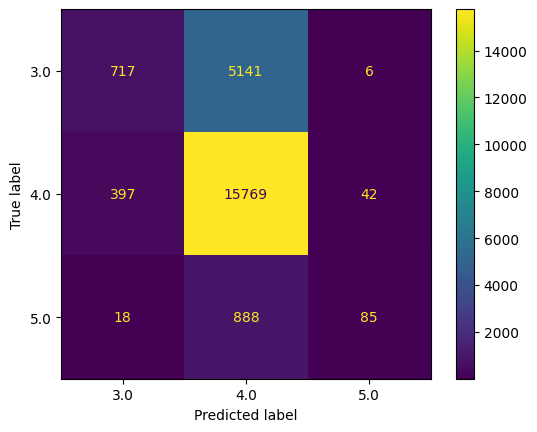

,mean,std
3.0_precision,0.634803,0.046193
3.0_recall,0.122264,0.015785
3.0_f1-score,0.204637,0.022711
4.0_precision,0.723426,0.002506
4.0_recall,0.972915,0.004911
4.0_f1-score,0.829815,0.002050
5.0_precision,0.631357,0.104609
5.0_recall,0.085818,0.027117
5.0_f1-score,0.150294,0.044977
accuracy,0.718510,0.003579


In [24]:
rf.fit(X_train[RF_FEATURES], y_train)
y_pred_rf, rf_report = cross_val_report(rf, X_train[RF_FEATURES], y_train)
rf_report

In [25]:
rf.oob_score_

0.718076572865629

## 2) StackingClassifier

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingCVClassifier

In [27]:
# Gaussian NB
gnb = GaussianNB()
# Linear SVM
linearSVM = svm.LinearSVC(random_state=30027, C=1)
# Logistic Regression
logr = LogisticRegression(solver='sag', max_iter=100)
# Decision tree
dt = DecisionTreeClassifier(max_depth = 400, random_state = 30027)
# 3NN
knn = KNeighborsClassifier(n_neighbors=3)

# Stack
sclf = StackingCVClassifier(classifiers=[gnb, linearSVM, logr, dt, knn], 
                            meta_classifier=LogisticRegression(),
                            cv=2,
                            random_state=30027)

sclf.fit(X_train, y_train)

StackingCVClassifier(classifiers=[GaussianNB(),
                                  LinearSVC(C=1, random_state=30027),
                                  LogisticRegression(solver='sag'),
                                  DecisionTreeClassifier(max_depth=400,
                                                         random_state=30027),
                                  KNeighborsClassifier(n_neighbors=3)],
                     meta_classifier=LogisticRegression(), random_state=30027)

StackingCVClassifier prediction took 393.7739448547363 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.733696    0.229983      0.350195       0.741875    0.971622   
1       0.721519    0.194208      0.306040       0.734979    0.973473   
2       0.769784    0.182594      0.295172       0.734195    0.981493   
3       0.737226    0.172355      0.279391       0.731550    0.978408   
4       0.801325    0.206485      0.328358       0.738283    0.981493   
5       0.677419    0.179181      0.283401       0.731628    0.970389   
6       0.762712    0.153584      0.255682       0.727938    0.982110   
7       0.771429    0.184300      0.297521       0.734166    0.979642   
8       0.751634    0.195911      0.310811       0.735472    0.976543   
9       0.746269    0.170358      0.277393       0.731797    0.980247   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.841346       0.000000    0.000000      0.000000  0.74

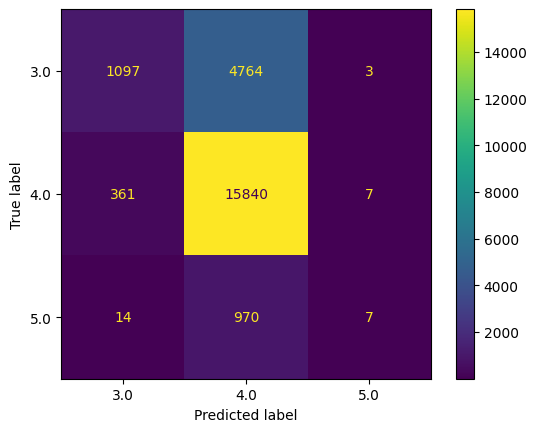

,mean,std
3.0_precision,0.747301,0.033497
3.0_recall,0.186896,0.021225
3.0_f1-score,0.298396,0.027195
4.0_precision,0.734188,0.003893
4.0_recall,0.977542,0.004325
4.0_f1-score,0.838555,0.002480
5.0_precision,0.383333,0.458460
5.0_recall,0.006051,0.007056
5.0_f1-score,0.011882,0.013846
accuracy,0.734770,0.004691


In [28]:
# This is slow - be patient!
y_pred_sclf, sclf_report = cross_val_report(sclf, X_train, y_train)
sclf_report

## 3) Logistic Regression

In [29]:
train_df_logr = pd.read_csv(DATASET_DIR + "train_df_ohe_300.csv", keep_default_na=False)
X_train_logr = train_df_logr.iloc[:,:-1]

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
logr = LogisticRegression(solver='sag', max_iter=500)  # uses Stochastic Average Gradient descent solver
logr.fit(X_train_logr, y_train)

LogisticRegression(max_iter=500, solver='sag')

In [32]:
selector = SelectFromModel(logr, prefit=True).fit(X_train_logr, y_train)
LR_FEATURES = [X_train_logr.columns[i] for i in selector.get_support(indices=True)]

LogisticRegression prediction took 41.14043712615967 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.751724    0.185690      0.297814       0.735937    0.976558   
1       0.708333    0.173765      0.279070       0.733830    0.972856   
2       0.810606    0.182594      0.298050       0.736842    0.984577   
3       0.707965    0.136519      0.228898       0.727482    0.976558   
4       0.776978    0.184300      0.297931       0.736671    0.980259   
5       0.731707    0.153584      0.253879       0.732225    0.978408   
6       0.756522    0.148464      0.248217       0.730487    0.981493   
7       0.720588    0.167235      0.271468       0.734107    0.975941   
8       0.767606    0.185690      0.299040       0.736647    0.979012   
9       0.732283    0.158433      0.260504       0.731978    0.977778   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.839343       0.727273    0.080808      0.145455  0.7368

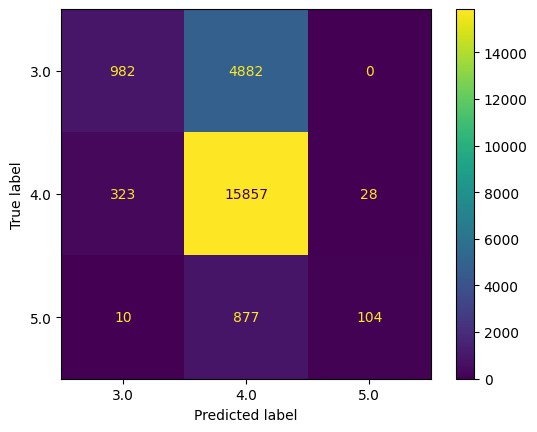

,mean,std
3.0_precision,0.746431,0.032737
3.0_recall,0.167627,0.017667
3.0_f1-score,0.273487,0.025079
4.0_precision,0.733620,0.003103
4.0_recall,0.978344,0.003257
4.0_f1-score,0.838487,0.002607
5.0_precision,0.796104,0.078643
5.0_recall,0.104970,0.019860
5.0_f1-score,0.184651,0.030971
accuracy,0.734683,0.004655


In [33]:
logr.fit(X_train_logr[LR_FEATURES], y_train)
y_pred_logr, logr_report = cross_val_report(logr, X_train_logr[LR_FEATURES], y_train)
logr_report

## 4) Stacking Naive Bayes

In [34]:
train_df_oe = pd.read_csv(DATASET_DIR + "train_df_oe.csv", keep_default_na=False)
y_train_oe = train_df_oe.iloc[:,-1]
X_train_oe = train_df_oe.iloc[:,:-1]

In [35]:
from mlxtend.classifier import StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB

In [36]:
GAUS_FEATURES = ['pagesNumber', 'PublishYear']
CAT_FEATURES = ['Authors']
MN_FEATURES = chi2_select_features(X_train_oe[X_train_oe.columns[6:]], y_train_oe)  # only filtering the text features
N_AUTHORS_VALS = len(ORD_ENCODER.categories_[0])  # number of unique Authors categories

X_train_oe = X_train_oe[GAUS_FEATURES + CAT_FEATURES + MN_FEATURES]
## X_train_oe

In [37]:
gnb = make_pipeline(ColumnSelector(GAUS_FEATURES),
                      GaussianNB())
cnb = make_pipeline(ColumnSelector(CAT_FEATURES),
                      CategoricalNB(alpha=0.11, min_categories=N_AUTHORS_VALS))
mnb = make_pipeline(ColumnSelector(MN_FEATURES),
                      MultinomialNB(alpha=0.26))

cvsnb = StackingCVClassifier(classifiers=[gnb, cnb, mnb], 
                            meta_classifier=CategoricalNB(),
                            random_state=30027)

cvsnb.fit(X_train_oe, y_train_oe)

StackingCVClassifier(classifiers=[Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=['pagesNumber',
                                                                        'PublishYear'])),
                                                  ('gaussiannb',
                                                   GaussianNB())]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=['Authors'])),
                                                  ('categoricalnb',
                                                   CategoricalNB(alpha=0.11,
                                                                 min_categories=19244))]),
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(cols=['world_war...
                                                                        'little_book',
                                                                        'year '
                                                                        'ago',
                                                                        'high '
                                                                        'school',
                                                                        'york '
                                                                        'time',
                                                                        'first '
                                                                        'book',
                                                                        'civil '
                                                                        'war',
                                                                        'also '
                                                                        'includes',
                                                                        'along '
                                                                        'way',
                                                                        'men '
                                                                        'woman',
                                                                        'book '
                                                                        'also',
                                                                        'award '
                                                                        'winning',
                                                                        'new '
                                                                        'edition',
                                                                        'nineteenth '
                                                                        'century',
                                                                        'science '
                                                                        'fiction',
                                                                        'real '
                                                                        'life',
                                                                        'href '
                                                                        'http',
                                                                        'brings '
                                                                        'together'])),
                                                  ('multinomialnb',
                                                   MultinomialNB(alpha=0.26))])],
                     meta_classifier=CategoricalNB(), random_state=30027)

StackingCVClassifier prediction took 0.6600949764251709 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0       0.601990    0.206133      0.307107       0.738521    0.942628   
1       0.590909    0.177172      0.272608       0.731372    0.950648   
2       0.621762    0.204778      0.308087       0.736968    0.950648   
3       0.630682    0.189420      0.291339       0.735795    0.958667   
4       0.693642    0.204778      0.316206       0.738739    0.961135   
5       0.629412    0.182594      0.283069       0.735447    0.958667   
6       0.629834    0.194539      0.297262       0.736441    0.954966   
7       0.619632    0.172355      0.269693       0.734249    0.956200   
8       0.655556    0.201022      0.307692       0.737042    0.956790   
9       0.655629    0.168654      0.268293       0.731925    0.962346   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.828184       0.540541    0.202020      0.294118  0.7

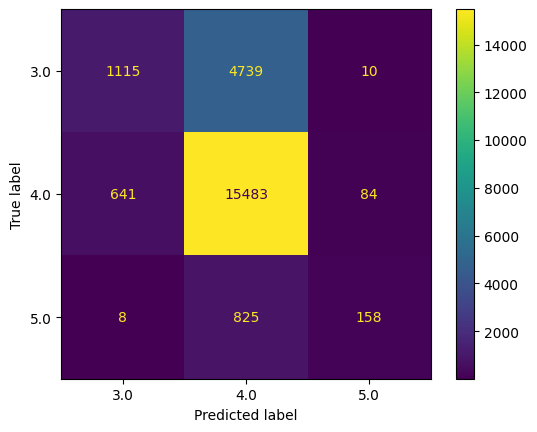

,mean,std
3.0_precision,0.632905,0.029372
3.0_recall,0.190145,0.014243
3.0_f1-score,0.292135,0.017834
4.0_precision,0.735650,0.002501
4.0_recall,0.955270,0.005901
4.0_f1-score,0.831187,0.002437
5.0_precision,0.636910,0.082189
5.0_recall,0.159455,0.024308
5.0_f1-score,0.253486,0.029887
accuracy,0.726532,0.003579


In [38]:
y_pred_cvsnb, cvsnb_report = cross_val_report(cvsnb, X_train_oe, y_train_oe)
cvsnb_report

## 5) Baselines

### 0R

DummyClassifier prediction took 0.2423868179321289 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0            0.0         0.0           0.0       0.702644         1.0   
1            0.0         0.0           0.0       0.702644         1.0   
2            0.0         0.0           0.0       0.702644         1.0   
3            0.0         0.0           0.0       0.702949         1.0   
4            0.0         0.0           0.0       0.702949         1.0   
5            0.0         0.0           0.0       0.702949         1.0   
6            0.0         0.0           0.0       0.702949         1.0   
7            0.0         0.0           0.0       0.702949         1.0   
8            0.0         0.0           0.0       0.702515         1.0   
9            0.0         0.0           0.0       0.702515         1.0   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.825356            0.0         0.0           0.0  0.702644

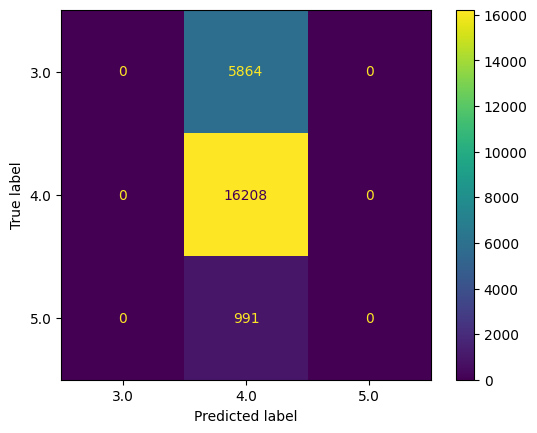

,mean,std
3.0_precision,0.000000,0.000000
3.0_recall,0.000000,0.000000
3.0_f1-score,0.000000,0.000000
4.0_precision,0.702771,0.000194
4.0_recall,1.000000,0.000000
4.0_f1-score,0.825444,0.000134
5.0_precision,0.000000,0.000000
5.0_recall,0.000000,0.000000
5.0_f1-score,0.000000,0.000000
accuracy,0.702771,0.000194


In [39]:
from sklearn.dummy import DummyClassifier

zero_r = DummyClassifier(strategy='most_frequent')
y_pred_zero_r, zero_r_report = cross_val_report(zero_r, X_train, y_train)
zero_r_report

### 1R

DecisionTreeClassifier prediction took 0.5394961833953857 seconds.

   3.0_precision  3.0_recall  3.0_f1-score  4.0_precision  4.0_recall  \
0            0.0         0.0           0.0       0.702644         1.0   
1            0.0         0.0           0.0       0.702644         1.0   
2            0.0         0.0           0.0       0.702644         1.0   
3            0.0         0.0           0.0       0.702949         1.0   
4            0.0         0.0           0.0       0.702949         1.0   
5            0.0         0.0           0.0       0.702949         1.0   
6            0.0         0.0           0.0       0.702949         1.0   
7            0.0         0.0           0.0       0.702949         1.0   
8            0.0         0.0           0.0       0.702515         1.0   
9            0.0         0.0           0.0       0.702515         1.0   

   4.0_f1-score  5.0_precision  5.0_recall  5.0_f1-score  accuracy  
0      0.825356            0.0         0.0           0.0  0

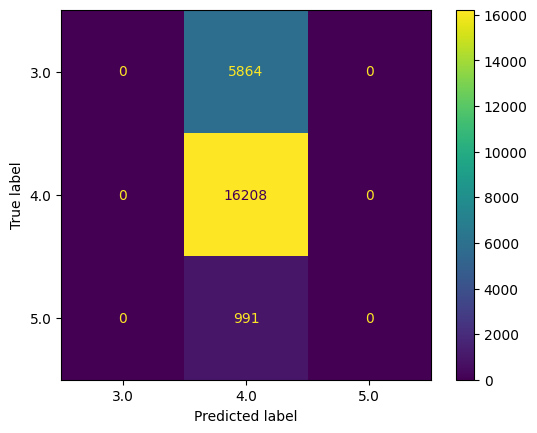

,mean,std
3.0_precision,0.000000,0.000000
3.0_recall,0.000000,0.000000
3.0_f1-score,0.000000,0.000000
4.0_precision,0.702771,0.000194
4.0_recall,1.000000,0.000000
4.0_f1-score,0.825444,0.000134
5.0_precision,0.000000,0.000000
5.0_recall,0.000000,0.000000
5.0_f1-score,0.000000,0.000000
accuracy,0.702771,0.000194


In [40]:
from sklearn.tree import DecisionTreeClassifier

one_r = DecisionTreeClassifier(max_depth=1)
y_pred_one_r, one_r_report = cross_val_report(one_r, X_train, y_train)
one_r_report

# 3. Final predictions on the test set

In [46]:
test_df = preprocess_test_df(test_df)
test_df_ohe = ohe_transform(test_df)

In [47]:
# Turns out that the StackingClf works the best - we use the same setting for the test set
X_test = test_df_ohe.drop(INSIG_OHE_FEATURES, axis=1)

In [48]:
y_pred = sclf.predict(X_test)

In [53]:
pred_df = pd.DataFrame(y_pred).reset_index().set_axis(['id', 'rating_label'], axis=1)
pred_df['id'] = pred_df['id']+1  # id starts from 1
pred_df.to_csv("predictions.csv", index=False)
pred_df

,id,rating_label
0,1,4.0
1,2,4.0
2,3,4.0
3,4,4.0
4,5,4.0
...,...,...
5761,5762,4.0
5762,5763,4.0
5763,5764,4.0
5764,5765,4.0
